In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sys import path
path.append('..')
path.append('../stationsim')

import ffmpeg
from stationsim.stationsim_model import Model
from stationsim.ukf import *
from stationsim.ukf_aggregate import *


from IPython.display import Video


## Unscented Kalman Filter

Using our established agent based model StationSim we wish to try and filter noisy measurements and improve prediction of agent positions. One such filter that can be used is the Unscented Kalman Filter. This filter was originially designed to apply traditional Kalman Filtering to non-linear functions and we wish to see if it is viable for StationSim as well.

In [2]:
np.random.seed(seed = 8) #hash if not needed.
# this seed (8) is a good example of an agent getting stuck given 10 agents
recall =True # recalling a pickled run or starting from scratch?
do_pickle =True # if not recalling do you want to pickle this run so you can recall it?

if not recall:

    model_params = {
    'pop_total': 5,

    'width': 200,
    'height': 100,

    'gates_in': 3,
    'gates_out': 2,
    'gates_space': 1,
    'gates_speed': 1,

    'speed_min': .2,
    'speed_mean': 1,
    'speed_std': 1,
    'speed_steps': 3,

    'separation': 5,
    'max_wiggle': 1,

    'step_limit': 3600,

    'do_history': True,
    'do_print': True,
    }
    """
    Sensor_Noise - how reliable are measurements H_x. lower value implies more reliable
    Process_Noise - how reliable is prediction fx lower value implies more reliable
    sample_rate - how often to update kalman filter. higher number gives smoother predictions

    prop - proportion of agents observed. this is a floor function that rounds the proportion 
    DOWN to the nearest intiger number of agents. 1 is all <1/pop_total is none

    bring_noise: add noise to true ukf paths
    noise: variance of said noise (0 mean)
    do_batch - do batch processing on some pre-recorded truth data.
    """

    filter_params = {      

    "Sensor_Noise":  1, 
    "Process_Noise": 1, 
    'sample_rate': 5,
    "prop": 0.5,
    "bring_noise":True,
    "noise":0.5,
    "do_batch":False,

    }

    """
    a - alpha between 1 and 1e-4 typically determines spread of sigma points.
    however for large dimensions may need to be even higher
    b - beta set to 2 for gaussian. determines trust in prior distribution.
    k - kappa usually 0 for state estimation and 3-dim(state) for parameters.
    not 100% sure what kappa does. think its a bias parameter.
    !! might be worth making an interactive notebook that varies these. for fun
    """

    ukf_params = {

    "a":1,
    "b":2,
    "k":0,

    }

    n = model_params["pop_total"]
    prop = filter_params["prop"]
    noise = filter_params["noise"]

    base_model = Model(**model_params)
    u = ukf_ss(model_params,filter_params,ukf_params,base_model)
    u.main()
    if do_pickle:
        f_name = f"ukf_experiments/ukf_pickle_{n}_{prop}_{noise}.pkl"
        f = open(f_name,"wb")
        pickle.dump(u,f)
        f.close()
        
else:
        "file name to recall from certain parameters or enter own"

        n = 30
        prop = 0.5 
        noise = 0.5
        
        file_name = f"ukf_pickle_{n}_{prop}_{noise}.pkl"
        print("recalling "+ file_name)
        f = open("ukf_experiments/"+file_name,"rb")
        u = pickle.load(f)
        f.close()
        filter_params = u.filter_params
        model_params = u.model_params

recalling ukf_pickle_30_0.5_0.5.pkl


Observed first then unobserved.


../stationsim/ukf.py:559: RuntimeWarning: Mean of empty slice
  time_means = np.nanmean(c,axis=1)
../stationsim/ukf.py:559: RuntimeWarning: Mean of empty slice
  time_means = np.nanmean(c,axis=1)


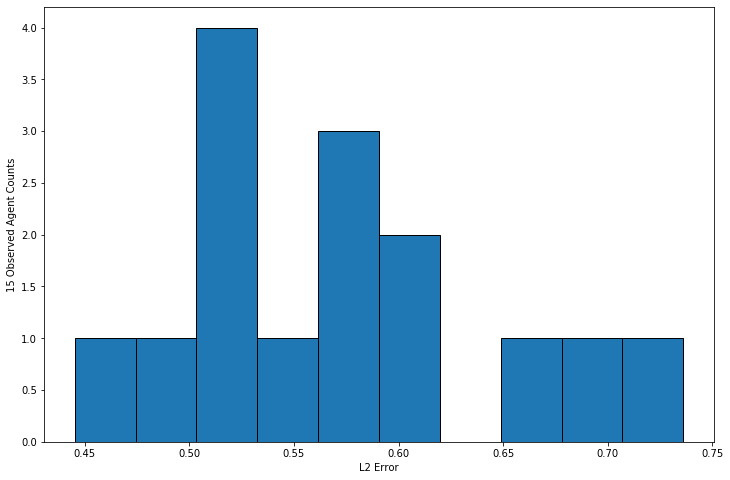

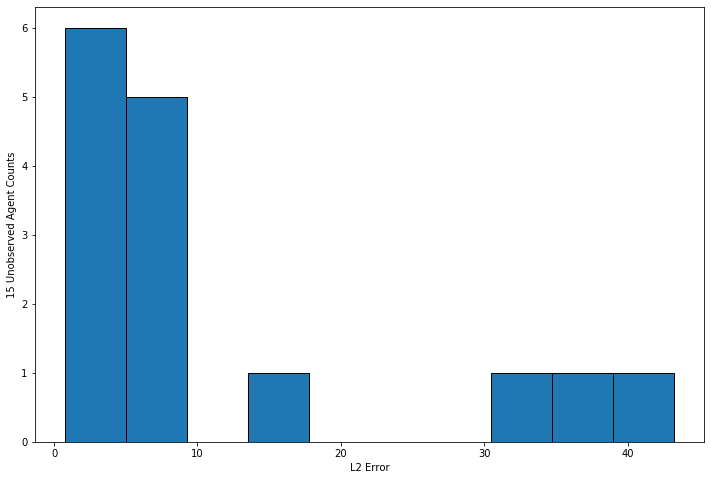

In [3]:
if filter_params["sample_rate"]>1:
    obs,preds,full_preds,truth,nan_array= u.data_parser(True)
else:
    obs,preds,truth,nan_array= u.data_parser(True)

preds[~nan_array]=np.nan #kill wierd tails of finished agents (remove this and see what happens)
full_preds[~nan_array]=np.nan #kill wierd tails of finished agents (remove this and see what happens)
truth[~nan_array]=np.nan

"initiate plot class using final instance of UKF. easier to do this that import numerous variables"
plts = plots(u,"ukf_experiments/")

"diagnostic plots, error matrices, and MAE over time"
print("Observed first then unobserved.")
save=True
distances2,t_mean2 = plts.diagnostic_plots(truth,preds,True,save) #observed
if filter_params["prop"]<1:
    distances,t_mean = plts.diagnostic_plots(truth,preds,False,save) #unobserved

In [4]:
if filter_params["sample_rate"]==1:
    #plts.pair_frames(actual,preds)
    #plts.heatmap(actual)
    plts.pair_frames_stack_ellipse(truth,preds)

else:
    plts.pair_frames(truth,full_preds)
    #plts.pair_frames_stack_ellipse(actual,full_preds)
    #plts.heatmap(actual)
    
print ("mp4 saved in:" + str(os.getcwd()) )
pop_total = model_params["pop_total"]
f_name = f'ukf_experiments/pairwise_gif_{pop_total}GIF.mp4'
Video(f_name,mimetype="mp4")


650 frames generated.
mp4 saved in:/home/rob/dust/Projects/ABM_DA/experiments


In [5]:
np.random.seed(seed = 8) #seeded example hash if want random
# this seed (8) is a good example of an agent getting stuck for 10 agents

recall = True #recall previous run
do_pickle = True #pickle new run
if not recall:
    """
        width - corridor width
        height - corridor height
        pop_total -population total
        entrances - how many entrances
        entrance speed- mean entry speed for agents
        exits - how many exits
        exit_space- how wide are exits 
        speed_min - minimum agents speed to prevent ridiculuous iteration numbers
        speed_mean - desired mean of normal distribution of speed of agents
        speed_std - as above but standard deviation
        speed_steps - how many levels of speed between min and max for each agent
        separation - agent radius to determine collisions
        wiggle - wiggle distance
        batch_iterations - how many model steps to do as a maximum
        3 do_ bools for saving plotting and animating data. 
    """
    model_params = {
            'pop_total': 30,

            'width': 200,
            'height': 100,

            'gates_in': 3,
            'gates_out': 2,
            'gates_space': 1,
            'gates_speed': 1,

            'speed_min': .2,
            'speed_mean': 1,
            'speed_std': 1,
            'speed_steps': 3,

            'separation': 5,
            'max_wiggle': 1,

            'step_limit': 3600,

            'do_history': True,
            'do_print': True,
        }
    """
    Sensor_Noise - how reliable are measurements H_x. lower value implies more reliable
    Process_Noise - how reliable is prediction fx lower value implies more reliable
    sample_rate - how often to update kalman filter. higher number gives smoother predictions
    prop - proportion of agents observed. this is a floor function that rounds the proportion 
        DOWN to the nearest intiger number of agents. 1 is all <1/pop_total is none
    bin_size - square sizes for aggregate plots,
    do_batch - do batch processing on some pre-recorded truth data.
    bring_noise - add noise to measurements?
    noise - variance of added noise
    """

    filter_params = {      

            "Sensor_Noise":  1, 
            "Process_Noise": 1, 
            'sample_rate': 5,
            "do_restrict": True, 
            "prop": 1,
            "bin_size":25,
            "bring_noise":True,
            "noise":0.5,
            "do_batch":False,
            }

    """
    a - alpha between 1 and 1e-4 typically determines spread of sigma points.
        however for large dimensions may need to be even higher
    b - beta set to 2 for gaussian. determines trust in prior distribution.
    k - kappa usually 0 for state estimation and 3-dim(state) for parameters.
        not 100% sure what kappa does. think its a bias parameter.
    !! might be worth making an interactive notebook that varies these. for fun
    """

    ukf_params = {
            "a":30,
            "b":2,
            "k":0,
            }

    """run and extract data"""
    base_model = Model(**model_params)
    poly_list = grid_poly(model_params["width"],model_params["height"],filter_params["bin_size"]) #generic square grid over corridor
    u_a = agg_ukf_ss(model_params,filter_params,ukf_params,poly_list,base_model)
    u_a.main()

    n = model_params["pop_total"]
    bin_size = filter_params["bin_size"]
    noise = filter_params["noise"]
    if do_pickle:
        f_name = f"ukf_agg_{n}_{bin_size}_{noise}.pkl"
        f = open("ukf_experiments/"+f_name,"wb")
        pickle.dump(u_a,f)
        f.close()

else:
    "file name to recall from certain parameters or enter own"
    n = 30
    noise= 0.5 
    bin_size = 25


    file_name = f"ukf_agg_pickle_{n}_{bin_size}_{noise}.pkl"
    print("recalling " +file_name)
    f = open("ukf_experiments/"+file_name,"rb")
    u_a = pickle.load(f)
    f.close()
    filter_params=u_a.filter_params

    poly_list =u_a.poly_list #generic square grid over corridor


recalling ukf_agg_pickle_30_25_0.5.pkl


../stationsim/ukf_aggregate.py:783: RuntimeWarning: Mean of empty slice
  time_means = np.nanmean(c,axis=1)


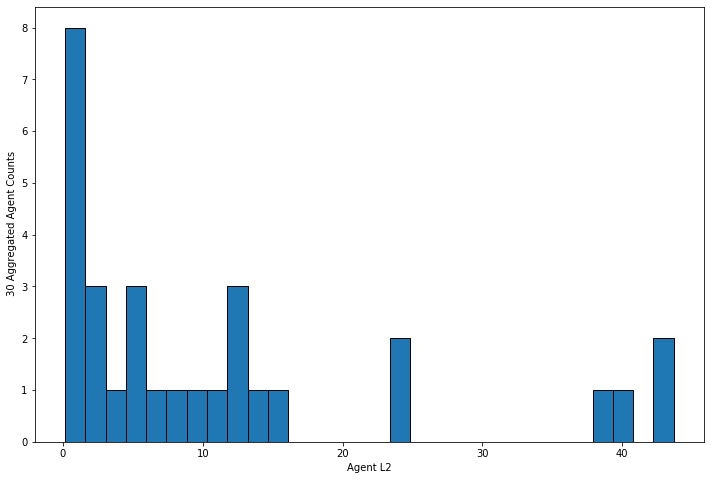

In [6]:
agg_plts = agg_plots(u_a,"ukf_experiments/")
aactual,apreds,afull_preds,atruth,anan_array= u_a.data_parser(True)
apreds[~anan_array]=np.nan #kill wierd tails of finished agents (remove this and see what happens)
afull_preds[~anan_array]=np.nan #kill wierd tails of finished agents (remove this and see what happens)
atruth[~anan_array]=np.nan
aactual = aactual[1:,:] #cut off wierd n/a start from StationSim

distances,t_mean = agg_plts.agg_diagnostic_plots(atruth,apreds,True)

In [7]:
agg_plts.pair_frames(atruth,afull_preds)
agg_plts.heatmap(atruth,poly_list)



862 frames generated.
862 frames generated.


In [10]:
pop_total = u_a.model_params["pop_total"]
f_name2 = agg_plts.save_dir+f'aggregate_pairwise_{pop_total}.mp4'
Video(f_name2,embed=True,mimetype="mp4")
f_name3 = agg_plts.save_dir+f'heatmap_{pop_total}_.mp4'
Video(f_name3,embed=True,mimetype="mp4")